Code for **"Activation maximization"** figure.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/deep-image-prior')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab*\nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab\n'

You can select net type (`vgg_16_caffe`, `vgg19_caffe`, `alexnet`) and a layer. For your reference the layer names for each network type are shown below.

In [3]:
vgg_19_names=['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
              'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
              'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','conv3_4','relu3_4','pool3',
              'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','conv4_4','relu4_4','pool4',
              'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','conv5_4','relu5_4','pool5',
              'torch_view','fc6','relu6','drop6','fc7','relu7','drop7','fc8']

vgg_16_names = ['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
                'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
                'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','pool3',
                'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5',
                'torch_view','fc6','relu6','drop6','fc7','relu7','fc8']

alexnet_names = ['conv1', 'relu1', 'norm1', 'pool1',
                 'conv2', 'relu2', 'norm2', 'pool2',
                 'conv3', 'relu3', 'conv4', 'relu4',
                 'conv5', 'relu5', 'pool5', 'torch_view',
                 'fc6', 'relu6', 'drop6',
                 'fc7', 'relu7', 'drop7',
                 'fc8', 'softmax']

The actual code starts here.

# Import libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from utils.perceptual_loss.perceptual_loss import *
from utils.common_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
fname = '/content/drive/MyDrive/deep-image-prior/data/feature_inversion/building.jpg'

# Choose net type
pretrained_net = 'alexnet_caffe'
assert pretrained_net in ['alexnet_caffe', 'vgg19_caffe', 'vgg16_caffe']

# Choose layers
layer_to_use = 'fc8'

ModuleNotFoundError: No module named 'models'

In [ ]:
import json
with open('/content/drive/MyDrive/deep-image-prior/data/imagenet1000_clsid_to_human.txt', 'r') as f:
    corresp = json.load(f)


if layer_to_use == 'fc8':
    # Choose class
    # name = 'black swan'
    name = 'cheeseburger'

    map_idx = None
    for k,v in corresp.items():
        if name in v:
            map_idx = int(k)
            break
else:
    map_idx = 2 # Choose here

# Setup pretrained net

In [ ]:
# Target imsize
imsize = 227 if pretrained_net == 'alexnet_caffe' else 224

# Something divisible by a power of two
imsize_net = 256

# VGG and Alexnet need input to be correctly normalized
preprocess, deprocess = get_preprocessor(imsize), get_deprocessor()


img_content_pil, img_content_np  = get_image(fname, -1)
img_content_prerocessed = preprocess(img_content_pil)[None,:].type(dtype)

In [ ]:
opt_content = {'layers': [layer_to_use], 'what':'features', 'map_idx': map_idx}

cnn = get_pretrained_net(pretrained_net).type(dtype)
cnn.add_module('softmax', nn.Softmax())

# Remove the layers we don't need
keys = [x for x in cnn._modules.keys()]
max_idx = max(keys.index(x) for x in opt_content['layers'])
for k in keys[max_idx+1:]:
    cnn._modules.pop(k)

print(cnn)

Sequential(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU()
  (norm1): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU()
  (norm2): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu4): ReLU()
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (torch_view): View()
  (fc6): Linear(in_features=9216, out_features=4096,

In [ ]:
matcher_content = get_matcher(cnn, opt_content)
matcher_content.mode = 'match'

if layer_to_use == 'fc8':
    matcher_content.mode = 'match'
    LR = 0.01
else:

    # Choose here
    # Window size controls the width of the region where the activations are maximized
    matcher_content.window_size = 20 # if = 1 then it is neuron maximization
    matcher_content.method = 'maximize'
    LR = 0.001

# Setup matcher and net

In [ ]:
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
net_input = get_noise(input_depth, INPUT, imsize_net).type(dtype).detach()
OPT_OVER = 'net' #'net,input'
pad='reflection'

tv_weight=0.0
reg_noise_std = 0.03
param_noise = True
num_iter = 3100

In [ ]:
net = skip(input_depth, 3, num_channels_down = [16, 32, 64, 128, 128, 128],
                           num_channels_up =   [16, 32, 64, 128, 128, 128],
                           num_channels_skip = [0, 4, 4, 4, 4, 4],
                           filter_size_down = [5, 3, 5, 5, 3, 5], filter_size_up = [5, 3, 5, 3, 5, 3],
                           upsample_mode='bilinear', downsample_mode='avg',
                           need_sigmoid=True, pad=pad, act_fun='LeakyReLU').type(dtype)





# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 2948567


In [ ]:
net(net_input).shape

torch.Size([1, 3, 256, 256])

### TV

Uncomment this section if you do not wan to optimize over pixels with TV prior only.

In [ ]:
# INPUT = 'noise'
# input_depth = 3
# net_input = (get_noise(input_depth, INPUT, imsize_net).type(dtype)+0.5).detach()

# OPT_OVER = 'input' #'net,input'
# net = nn.Sequential()
# reg_noise_std =0.0
# OPTIMIZER = 'adam'# 'LBFGS'
# LR = 0.01
# tv_weight=1e-6

# Optimize

/tmp/ipython-input-2966899098.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  mask[:,:, i, j] = 1 - min(100./d, 1)


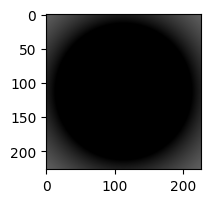

In [ ]:
mask = net_input.clone()[:,:3,:imsize,:imsize] * 0
for i in range(imsize):
    for j in range(imsize):
        d = np.sqrt((i - imsize//2)**2 + (j - imsize//2)**2)
        # if d > 75:
        mask[:,:, i, j] = 1 - min(100./d, 1)

plot_image_grid([torch_to_np(mask)]);
use_mask = False

In [ ]:
from utils.sr_utils import tv_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()


outs = []

def closure():

    global i, net_input

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std()/50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)[:, :, :imsize, :imsize]

#     out = out* (1-mask)


    cnn(vgg_preprocess_caffe(out))
    total_loss =  sum(matcher_content.losses.values()) * 5

    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(vgg_preprocess_caffe(out), beta=2)


    if use_mask:
        total_loss += nn.functional.mse_loss(out * mask, mask * 0, size_average=False) * 1e1

    total_loss.backward()

    print ('Iteration %05d    Loss %.3f' % (i, total_loss.item()), '\r', end='')
    if PLOT and  i % 100==0:
        out_np = np.clip(torch_to_np(out), 0, 1)
        plot_image_grid([out_np], 3, 3, interpolation='lanczos');

        outs.append(out_np)
    i += 1

    return total_loss

In [ ]:
i=0

p = get_params(OPT_OVER, net, net_input)

optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

# Result

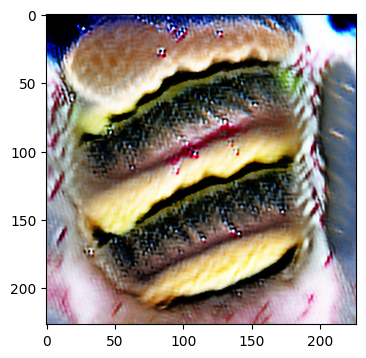

In [ ]:
out = net(net_input)[:, :, :imsize, :imsize]
plot_image_grid([torch_to_np(out)], 3, 3);